<img src='./img/LogoWekeo_Copernicus_RGB_0.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='20%'></img>

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./21_sentinel3_olci_l1_load_browse.ipynb"><< 21 - Sentinel-3 OLCI Level 1B - Load and browse</a><span style="float:right;"><a href="./30_cams_eac4_retrieve.ipynb">30 - CAMS EAC4 - Retrieve >></a></span>

<div class="alert alert-block alert-success">
<b>EXERCISE WORKBOOK</b></div>

# Sentinel-3 OLCI Level 1B data

This notebook is an `exercise workbook`, where you can practise the data handling with Sentinel-3 OLCI Level 1B data. The exercises base on the workflow introduced in the notebook [21 - Sentinel-3 OLCI Level 1B - Load and browse](./21_sentinel3_l1_load_browse.ipynb). We highly recommend that  you go through this notebook before you do this exercise workbook.

### How it works

This exercise workbook consists of two types of exercises:

#### Coding assignments
Coding assignments ask you to fill an empty code cell with code. Code exercises base on the notebook [21 - Sentinel-3 OLCI Level 1B - Load and browse](./21_sentinel3_olci_l1_load_browse.ipynb).

You recognize `coding assignments` as the yellow-coloured boxes.

<div class="alert alert-block alert-warning">
<b>Coding assignment</b>
</div>

#### Questions

Questions ask you to reflect on a result and output. `Questions` are provided as green-coloured boxes.

<div class="alert alert-block alert-success">
<b>Question</b>
</div>

<br>

### Outline

* [1. Load Sentinel-3 OLCI channel information as a xarray Dataset](#load)
* [2. Plot one Sentinel-3 OLCI channel information](#plot_channel)
* [3. Load OLCI geographic coordinates](#load_geo_coords)
* [4. Select OLCI channels for a RGB image](#channel_select)
* [5. Apply advanced image processing techniques - Normalization and histogram equalization](#image_processing)
* [6. Georeference the RGB image and visualize it](#georeference)
* [7. Create a False Color RGB image and plot it as georeferenced image](#false_color)

<hr>

#### Load required libraries

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from skimage import exposure

import glob

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [3]:
from ipynb.fs.full.functions import select_channels_for_rgb, normalize, visualize_s3_pcolormesh

<hr>

## <a id='load_browse'></a>Exercise example - California fires - Summer 2020

This exercise aims to get familiar with Sentinel-3 OLCI Level 1B data. The exercise examines the Californian wildfires that occured in in August and September 2020.

### <a id='load'></a>1. Load Sentinel-3 OLCI channel information as a xarray Dataset

Let us define the directory where the Sentinel-3 data for the Californian fire example are stored. We can also loop through the directory and see the files available

In [7]:
olci_dir = './data/sentinel_3/2020/09/07/S3B_OL_1_EFR____20200907T181635_20200907T181935_20200908T214254_0179_043_141_2340_LN1_O_NT_002.SEN3/'
for i in glob.glob(olci_dir+'*.nc'):
    tmp = i.split('/')
    print(tmp[7])

Oa17_radiance.nc
Oa02_radiance.nc
instrument_data.nc
Oa07_radiance.nc
tie_geometries.nc
Oa20_radiance.nc
tie_meteo.nc
Oa12_radiance.nc
Oa11_radiance.nc
Oa18_radiance.nc
Oa04_radiance.nc
Oa01_radiance.nc
Oa14_radiance.nc
Oa08_radiance.nc
qualityFlags.nc
Oa13_radiance.nc
geo_coordinates.nc
Oa21_radiance.nc
removed_pixels.nc
Oa06_radiance.nc
tie_geo_coordinates.nc
Oa03_radiance.nc
Oa16_radiance.nc
Oa09_radiance.nc
Oa15_radiance.nc
Oa05_radiance.nc
time_coordinates.nc
Oa19_radiance.nc
Oa10_radiance.nc


<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

Enter below the code which loads all channel information of the folder defined above as xarray Dataset. Call the dataset **olci_xr_mf**. <br>
<br>


**Note:** 
Remember that xarray has a function `open_mfdataset()` that allows to open multiple netcdf files at once.
</div>

In [ ]:
# Enter your solution here






In [8]:
olci_xr_mf = xr.open_mfdataset(olci_dir+'*_radiance.nc', combine='by_coords')
olci_xr_mf

<xarray.Dataset>
Dimensions:        (columns: 4865, rows: 4091)
Dimensions without coordinates: columns, rows
Data variables:
    Oa01_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa04_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa05_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa06_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa07_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa08_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa09_radiance  (rows, columns) float32 dask.array<chunksize=(4091, 4865), meta=np.ndarray>
    Oa10_radiance  

<div class="alert alert-block alert-success">
<b>Question:</b><br>

Have a look at Dataset **olci_xr_mf** above and investigate the dataset:
- What is the dimension of the dataset?
- How many data variables does it contain?
</div>

The dataset **olci_xr_mf** has two dimensions: `columns` and `rows`. The dataset has 4865 column entries and 4091 row entries.

The dataset has `21 data variables`; each Sentinel-3 OLCI channel representes one variable.

<br>

### <a id='plot_channel'></a>2. Plot one Sentinel-3 OLCI channel information

To get an impression of the image, plot one channel (one data variable) of the loaded Dataset.

<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

Enter below the code which plots one data variable of the Dataset **olci_xr_mf**, e.g the data variable `Oa20_radiance`.<br> Change the data variable and re-plot it. <br>
<br>

**Note:** 
Make use of xarray's built in visualization functions, such as `xr.plot.imshow()`.
</div>

In [9]:
# Enter your solution here






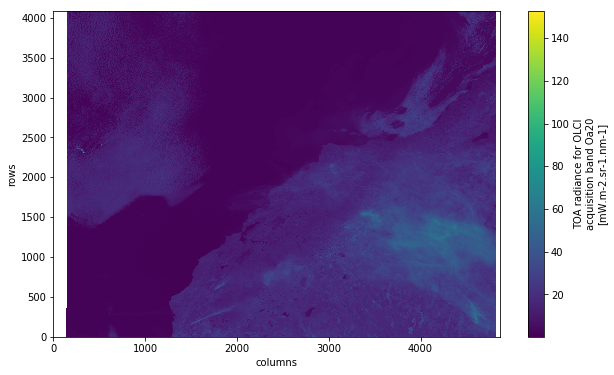

In [13]:
fig = plt.figure(figsize=(10,6))
olci_xr_mf['Oa20_radiance'].plot.imshow()

<br>

### <a id='load_geo_coords'></a>3. Load OLCI geographic coordinates

Eventually, we are interested in geo-referencing the Sentinel-3 OLCI image. For this reason, the next step is to load the **geo_coordinates.nc** file as xarray Dataset.

<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

Enter below the code that loads the file `geo_coordinates.nc` as `xarray Dataset`. Once loaded, store the `latitude` and `longitude` information separately as data variables and call them `lat` and `lon` respectively. <br>


</div>

In [ ]:
# Enter your solution here






In [14]:
olci_geo_coords = xr.open_dataset(olci_dir+'geo_coordinates.nc')
print(olci_geo_coords)

lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data

<xarray.Dataset>
Dimensions:    (columns: 4865, rows: 4091)
Dimensions without coordinates: columns, rows
Data variables:
    altitude   (rows, columns) float32 ...
    latitude   (rows, columns) float64 ...
    longitude  (rows, columns) float64 ...
Attributes:
    absolute_orbit_number:  12348
    ac_subsampling_factor:  64
    al_subsampling_factor:  1
    comment:                 
    contact:                eosupport@copernicus.esa.int
    creation_time:          2020-09-08T21:42:54Z
    history:                  2020-09-08T21:42:54Z: PUGCoreProcessor /data/ip...
    institution:            LN1
    netCDF_version:         4.2 of Mar 13 2018 10:14:33 $
    product_name:           S3B_OL_1_EFR____20200907T181635_20200907T181935_2...
    references:             S3IPF PDS 004.1 - i2r2 - Product Data Format Spec...
    resolution:             [ 270 294 ]
    source:                 IPF-OL-1-EO 06.08
    start_time:             2020-09-07T18:16:35.055223Z
    stop_time:              202

<div class="alert alert-block alert-success">
<b>Question:</b><br>

What are the geographic bounds of the dataset?

**Note:**
You can make use of xarray's built-in functions `xr.max()` and `xr.min()` to retrieve minimum and maxiumum values of a variable.
</div>

**Latitude**:
- min: 29.0885599999999998
- max: 41.989984

**Longitude**:
- min: -129.927426
- max: -112.95917399999999

<br>

### <a id='channel_select'></a>4. Select OLCI channels for a RGB image

Let us select three different channels representing the three different bands `red`, `green` and `blue`.

<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

Enter below the code that selects three channels (data variables) from the dataset **olci_xr_mf** with the help of the function [select_channels_for_rgb](./functions.ipynb#rgb_channels). Use channel the following combination:
- **red**: channel 08
- **green**: channel 06
- **blue**: channel 04 <br>

Try out different channel combinations.
<br>

<b>NOTE:</b><br> With `?select_channels_for_rgb`, you can see what keyword arguments the function requires.
</div>

In [41]:
?select_channels_for_rgb

In [ ]:
# Enter your solution here







In [22]:
red, green, blue = select_channels_for_rgb(olci_xr_mf, 'Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance')
red

<xarray.DataArray 'Oa08_radiance' (rows: 4091, columns: 4865)>
dask.array<open_dataset-ae45b6cda96a4d07f22460112a2a60a5Oa08_radiance, shape=(4091, 4865), dtype=float32, chunksize=(4091, 4865)>
Dimensions without coordinates: rows, columns
Attributes:
    ancillary_variables:  Oa08_radiance_err
    coordinates:          time_stamp altitude latitude longitude
    long_name:            TOA radiance for OLCI acquisition band Oa08
    standard_name:        toa_upwelling_spectral_radiance
    units:                mW.m-2.sr-1.nm-1
    valid_max:            65534
    valid_min:            0

<div class="alert alert-block alert-success">
<b>Question:</b><br>

What are the attributes **long_name** and **units** of e.g. the red channel?

</div>

**Long_name**: TOA radiance for OLCI acquisiation band Oa08

**Units**: mW.m-2.sr-1.nm-1

<br>

### <a id='image_processing'></a>5. Apply advanced image processing techniques - Normalization and histogram equalization

Common operations in image processing are **normalization** and **historgram equalization** in order to improve the contrast and data range.
Let us first `normalize` the three selected channels and visualize it and in a second step apply a `histogram equalization` and visualize it as well.

<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

Enter below the code that does the following three steps:
- Normalization of the values of each channel and call the new data variables **redn**, **greenn** and **bluen** respectively
- Stack together the three channels into a `numpy.dstack` with the function `np.dstack` and call the numpy stack **rgb**, and
- Visualization of the stacked numpy array with `plt.imshow()`.<br>

<br>

<b>NOTE:</b><br> With `?normalize`, you can see what keyword arguments the function requires.
</div>

In [ ]:
?normalize

In [ ]:
# Enter your solution here







(4091, 4865, 3)


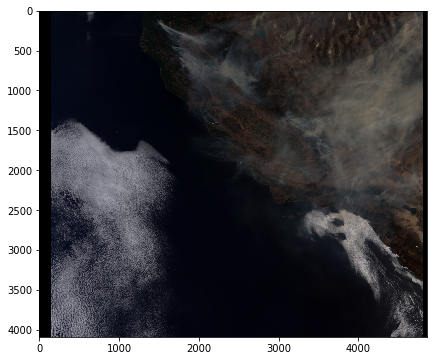

In [29]:
# 1. Normalize the values of the three channels
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

# 2. Stack the normalized channels together into a `numpy stack`
rgb = np.dstack((redn, greenn, bluen))
print(rgb.shape)

# 3. Plot the stacked numpy array
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)

<div class="alert alert-block alert-success">
<b>Question:</b><br>

What is the shape (dimensions) of the resulting numpy array **rgb**?

</div>

The stacked numpy array has three dimensions: (4091, 4865, 3).

<br>

The visualized rgb above shows that it might be helpful to sharpen the contrast. Let us apply a `histogram equalization` on the stacked array **rgb**.

<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

Enter below the code that does the following two steps:
- Histogram equalization of the stacked array **rgb**. Use the function `exposure.equalize_adapthist()` from Python's skikit-learn library. Call the new stacked array **rgb_equalized** 
- Visualization of the stacked numpy array with the equalized histogram

</div>

In [ ]:
# Enter your solution here







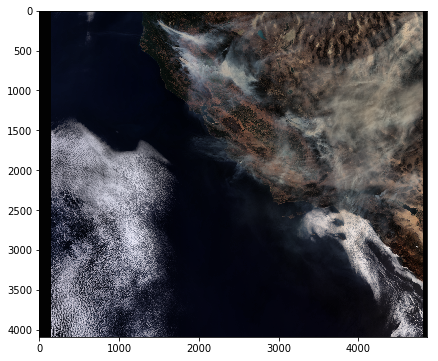

In [30]:
# 1. Histogram equalization
rgb_equalized = exposure.equalize_adapthist(rgb)

# 2. Visualization of the array with the equalized histogram
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb_equalized)

<br>

### <a id='georeference'></a>6. Georeference the RGB image and visualize it

The final step is to georeference the `RGB` image. Therefore, you need the extracted `lat` and `lon` information extracted above.

The first step is to create a mesh grid that maps the rgb array values onto a array of colour values. The second step is then to visualize the georeferenced image.

<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

Enter below the code that creates a mesh grid, which maps the **rgb_equalized** array values onto an array of colour values. Call the meshed array **colorTuple**.
Use the `mesh_rgb.reshape` function for it.

</div>

In [ ]:
# Enter you solution here






In [31]:
mesh_rgb = rgb[:, :-1, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

<b>

The last step is to visualize the color array and add additional information, e.g. gridlines and coastlines.

<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

Enter below the code that visualizes the georeferenced mesh **colorTuple** as a georeferenced image. Make use of the function [visualize_s3_pcolormesh](./functions.ipynb#visualize_s3_pcolormesh).
Use the following input arrays:
- **colorTuple** as color array and
- **red** as array<br><br>

<b>NOTE:</b><br> With `?visualize_s3_pcolormesh`, you can see what keyword arguments the function requires.
</div>

In [34]:
?visualize_s3_pcolormesh

In [ ]:
# Enter your solution here







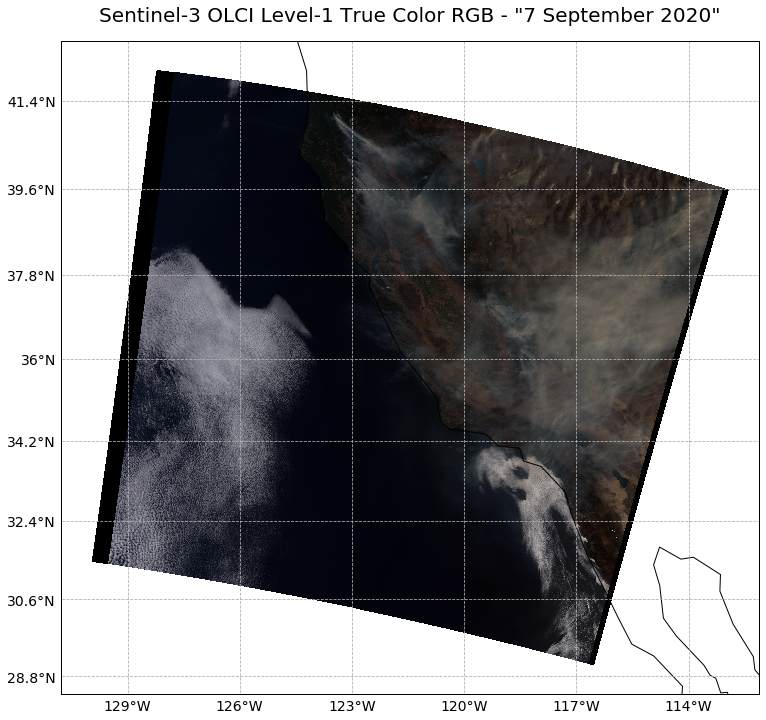

In [37]:
visualize_s3_pcolormesh(colorTuple, red, lat, lon, 'Sentinel-3 OLCI Level-1 True Color RGB - "7 September 2020"')

<br>

### <a id='false_color'></a>7. Create a False Color RGB image and plot it as georeferenced image 

Now it is your turn - repeat the steps above and create a `False Color RGB` and plot it as a georeference image.

A false color RGB image can be applied if specific phenomena should be highlighted. A channel combination for Sentinel-3 OLCI data to identify burnt areas and wildfires could be:
- Red: `Oa17_radiance`
- Green: `Oa05_radiance`
- Blue: `Oa02_radiance`

<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

Enter the code in the respective code cells in order to execute the following tasks:
1. Select RGB channels with the function [select_channels_for_rgb](./functions.ipynb#select_channels_for_rgb) and use the above channel combination for wildfires and burnt areas.
2. Normalize the selected channels with the function [normalize](./functions.ipynb#normalize)
3. Create a RGB stacked array with `np.dstack`
4. Apply a histogram equalization with the function `exposure.equalize_adapthist`
5. Create a mesh array that maps the array values onto a colour grid
6. Visualize the georeferenced image with the function [visualize_s3_pcolormesh](./functions.ipynb#visualize_s3_pcolormesh)
</div>

In [ ]:
# Enter you solution here







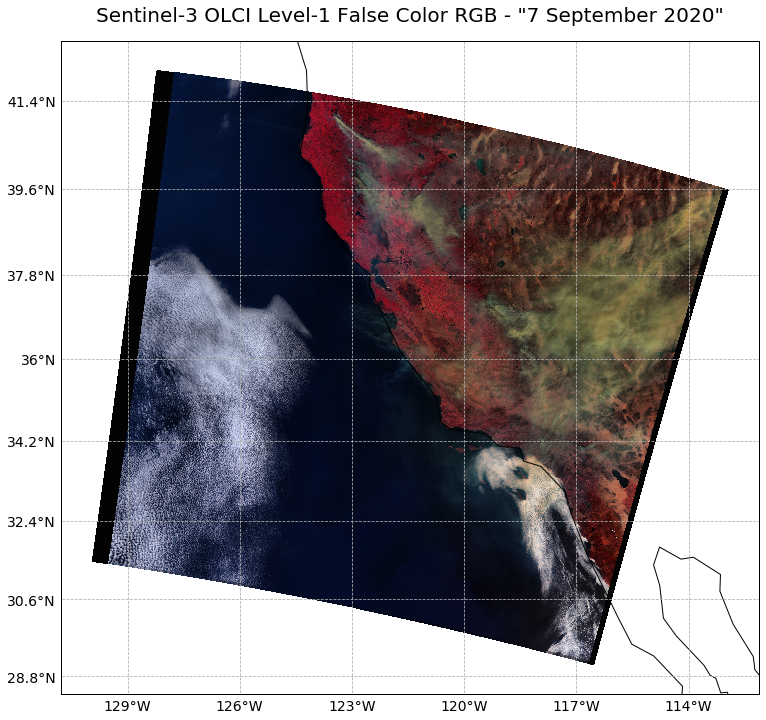

In [40]:
# 1. Select False Color RGB channels
red_fc, green_fc, blue_fc = select_channels_for_rgb(olci_xr_mf, 'Oa17_radiance', 'Oa05_radiance', 'Oa02_radiance')

# 2. Normalize the data of the selected channels
redn_fc = normalize(red_fc)
greenn_fc = normalize(green_fc)
bluen_fc = normalize(blue_fc)

# 3. Create a RGB stacked array
rgb_fc = np.dstack((redn_fc, greenn_fc, bluen_fc))

# 4. Apply histogram equalization
rgb_fc = exposure.equalize_adapthist(rgb_fc)

# 5. Create a mesh array that maps the array values onto a colour grid
mesh_rgb = rgb_fc[:, :-1, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

# 6. Visualize the georeference RGB image
visualize_s3_pcolormesh(colorTuple, red_fc, lat, lon, 'Sentinel-3 OLCI Level-1 False Color RGB - "7 September 2020"')

<br>

The False-Colour image shows well smoke resulting from fires occurring at the Californian coast in August and September 2020.

This is the end of the exercise workbook and we hope that you feel more familiar with the Sentinel-3 OLCI Level-1B data and understand how you can use the data for fire monitoring.

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./21_sentinel3_olci_l1_load_browse.ipynb"><< 21 - Sentinel-3 OLCI Level 1 - Load and browse</a><span style="float:right;"><a href="./30_cams_eac4_retrieve.ipynb">30 - CAMS EAC4 - Retrieve >></a></span>

<hr>

<img src='./img/all_partners_wekeo.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='100%'></img>